In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st
import seaborn as sns
sns.set_style('white')


# Formating for the entire excercise
pd.options.display.float_format = "{:,.2f}".format

In [2]:
# Read the CSV with the full data from Diabetes dataset (https://gis.cdc.gov/grasp/diabetes/DiabetesAtlas.html)

diabetes_csv = "Data/National_Data.csv"
diabetes_df = pd.read_csv(diabetes_csv)
diabetes_df

,yearid,fipscode,raceid,ageid,genderid,educationid,indicatorid,miscid,datasourceid,estimateid,SuppressID,datasetid,GeoLevel,Estimate,SeEstimate,LowerLimit,UpperLimit
0,1980,-1,0,5,0,0,1,0,30,61,0,40,National,1,0.1,0.9,1.2
1,1980,-1,0,5,0,0,1,0,30,101,0,40,National,915,76,764,1065
2,1980,-1,0,6,0,0,1,0,3,61,0,3,National,5.4,0.3,4.8,6
3,1980,-1,0,6,0,0,1,0,3,101,0,3,National,2337,143,2054,2621
4,1980,-1,0,6,0,0,1,0,30,61,0,40,National,5.4,0.3,4.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29097,2017,-1,1,100,0,0,2,0,3,72,0,31,National,6.1,0.5,5.2,7.1
29098,2017,-1,2,99,0,0,2,0,3,72,0,31,National,8.7,1.2,6.6,11.5
29099,2017,-1,2,100,0,0,2,0,3,72,0,31,National,9.2,1.3,7,12.1
29100,2017,-1,7,99,0,0,2,0,3,72,0,31,National,9.7,1.6,7,13.4


In [3]:
# Get a list of all of our columns for easy reference.

diabetes_df.columns

Index(['yearid', 'fipscode', 'raceid', 'ageid', 'genderid', 'educationid',
       'indicatorid', 'miscid', 'datasourceid', 'estimateid', 'SuppressID',
       'datasetid', 'GeoLevel', 'Estimate', 'SeEstimate', 'LowerLimit',
       'UpperLimit'],
      dtype='object')

In [4]:
# Reduce DF to allocate just the columns needed (indicatorid / ageid / estimateid / datasetid / raceid / yearid)

diabetes_race_df = diabetes_df.loc[:, ["indicatorid", "ageid", "estimateid", "datasetid", "raceid", "yearid","Estimate"]]
diabetes_race_df


,indicatorid,ageid,estimateid,datasetid,raceid,yearid,Estimate
0,1,5,61,40,0,1980,1
1,1,5,101,40,0,1980,915
2,1,6,61,3,0,1980,5.4
3,1,6,101,3,0,1980,2337
4,1,6,61,40,0,1980,5.4
...,...,...,...,...,...,...,...
29097,2,100,72,31,1,2017,6.1
29098,2,99,72,31,2,2017,8.7
29099,2,100,72,31,2,2017,9.2
29100,2,99,72,31,7,2017,9.7


In [5]:
# Race DF. Rename the raceid indicator using cut/bins.

# Create bins in which to place values based on races.
bins = [0,1,2,3,7]

# Create labels for these bins
labels = ["White", "Black", "Asian", "Hispanic"]

# Slice the data and place it into bins
diabetes_race_df["Race"] = pd.cut(diabetes_df["raceid"], bins, labels=labels)
diabetes_race_df


,indicatorid,ageid,estimateid,datasetid,raceid,yearid,Estimate,Race
0,1,5,61,40,0,1980,1,NaN
1,1,5,101,40,0,1980,915,NaN
2,1,6,61,3,0,1980,5.4,NaN
3,1,6,101,3,0,1980,2337,NaN
4,1,6,61,40,0,1980,5.4,NaN
...,...,...,...,...,...,...,...,...
29097,2,100,72,31,1,2017,6.1,White
29098,2,99,72,31,2,2017,8.7,Black
29099,2,100,72,31,2,2017,9.2,Black
29100,2,99,72,31,7,2017,9.7,Hispanic


In [6]:
# Create a new df with the parameters by each variable / 1,000s (estimateid = 101)

race_analysis_pop = diabetes_race_df.loc[(diabetes_race_df["indicatorid"] == 1) & (diabetes_race_df["ageid"]== 99) & \
                  (diabetes_race_df["estimateid"] == 101) & (diabetes_race_df["datasetid"] == 3) & \
                  (diabetes_race_df["yearid"] >= 2000)].dropna()

race_analysis_pop = race_analysis_pop.reset_index()

race_analysis_pop

,index,indicatorid,ageid,estimateid,datasetid,raceid,yearid,Estimate,Race
0,1384,1,99,101,3,1,2000,9169,White
1,1390,1,99,101,3,2,2000,2003,Black
2,1396,1,99,101,3,3,2000,258,Asian
3,1402,1,99,101,3,7,2000,1345,Hispanic
4,1451,1,99,101,3,1,2001,10025,White
...,...,...,...,...,...,...,...,...,...
67,27330,1,99,101,3,7,2016,3740,Hispanic
68,28244,1,99,101,3,1,2017,17560,White
69,28250,1,99,101,3,2,2017,3345,Black
70,28256,1,99,101,3,3,2017,1354,Asian


In [7]:
# Check what type are each variable

race_analysis_pop.dtypes

index             int64
indicatorid       int64
ageid             int64
estimateid        int64
datasetid         int64
raceid            int64
yearid            int64
Estimate         object
Race           category
dtype: object

In [8]:
# Convert "Estimate" variable into integer to be able to sum.

race_analysis_pop['Estimate'] = pd.to_numeric(race_analysis_pop['Estimate'])
race_analysis_pop.dtypes

index             int64
indicatorid       int64
ageid             int64
estimateid        int64
datasetid         int64
raceid            int64
yearid            int64
Estimate          int64
Race           category
dtype: object

In [9]:
# Using .pivot_table create the dataframe to plot (https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)

race_table_pop = race_analysis_pop.pivot_table(values=["Estimate"], index=["yearid"], columns=["Race"])
race_table_pop

Estimate                     
Race      White Black Asian Hispanic
yearid                              
2000       9169  2003   258     1345
2001      10025  2068   267     1506
2002      10430  2094   363     1561
2003      11281  2125   355     1574
2004      11884  2426   519     1884
2005      13009  2522   437     1922
2006      13252  2888   696     2182
2007      12999  2905   825     2346
2008      14680  2766   741     2548
2009      15998  3339   779     2883
2010      16286  3287   897     3208
2011      15920  3264   916     3048
2012      16328  3469  1005     3208
2013      17228  3334   987     3423
2014      16621  3663   987     3473
2015      17501  3743  1194     3633
2016      17582  3774  1079     3740
2017      17560  3345  1354     4118

In [10]:
# Create a new df with the parameters by each variable / Percentage (estimateid = 61)

race_analysis_per = diabetes_race_df.loc[(diabetes_race_df["indicatorid"] == 1) & (diabetes_race_df["ageid"]== 99) & \
                  (diabetes_race_df["estimateid"] == 61) & (diabetes_race_df["datasetid"] == 3) & \
                  (diabetes_race_df["yearid"] >= 2000)].dropna()

race_analysis_per = race_analysis_per.reset_index()
race_analysis_per['Estimate'] = pd.to_numeric(race_analysis_per['Estimate'])

race_analysis_per

,index,indicatorid,ageid,estimateid,datasetid,raceid,yearid,Estimate,Race
0,1383,1,99,61,3,1,2000,4.20,White
1,1389,1,99,61,3,2,2000,6.00,Black
2,1395,1,99,61,3,3,2000,2.90,Asian
3,1401,1,99,61,3,7,2000,4.10,Hispanic
4,1450,1,99,61,3,1,2001,4.60,White
...,...,...,...,...,...,...,...,...,...
67,27329,1,99,61,3,7,2016,6.60,Hispanic
68,28242,1,99,61,3,1,2017,7.20,White
69,28248,1,99,61,3,2,2017,8.10,Black
70,28254,1,99,61,3,3,2017,6.80,Asian


In [11]:
# Using .pivot_table create the dataframe to plot (https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)

race_table_per = race_analysis_per.pivot_table(values=["Estimate"], index=["yearid"], columns=["Race"])
race_table_per

Estimate                     
Race      White Black Asian Hispanic
yearid                              
2000       4.20  6.00  2.90     4.10
2001       4.60  6.10  2.90     4.40
2002       4.70  6.20  3.70     4.40
2003       4.80  6.00  3.70     4.00
2004       5.10  6.80  4.90     4.60
2005       5.50  7.00  4.10     4.60
2006       5.60  7.70  5.40     5.00
2007       5.50  7.70  6.20     5.20
2008       6.20  7.30  5.50     5.50
2009       6.70  8.60  5.70     6.00
2010       6.70  8.50  6.20     6.50
2011       6.60  8.40  6.10     6.10
2012       6.70  9.00  6.30     6.10
2013       7.10  8.50  5.90     6.40
2014       6.80  9.10  5.60     6.40
2015       7.10  9.20  6.50     6.50
2016       7.10  9.30  5.70     6.60
2017       7.20  8.10  6.80     7.10

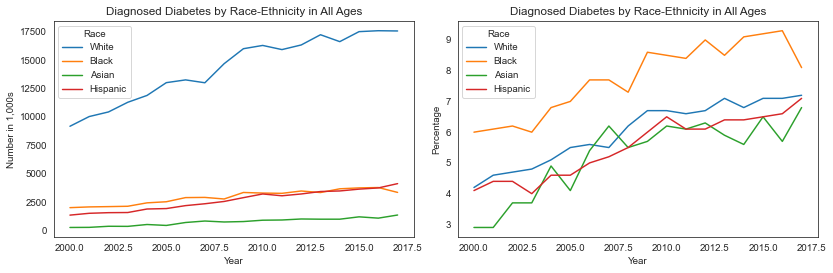

In [12]:
# Create a plot - for the dataset (https://seaborn.pydata.org/generated/seaborn.lineplot.html)

fig,axes = plt.subplots(nrows=1,ncols=2,dpi=70,figsize = (12,4))

plot00= sns.lineplot(data=race_analysis_pop, x="yearid", y="Estimate", hue="Race", ax=axes[0])
axes[0].set_title("Diagnosed Diabetes by Race-Ethnicity in All Ages")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number in 1,000s")
# plt.xticks(rotation="vertical")
plt.tight_layout()


plot01= sns.lineplot(data=race_analysis_per, x="yearid", y="Estimate", hue="Race",ax=axes[1])
axes[1].set_title("Diagnosed Diabetes by Race-Ethnicity in All Ages")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Percentage")
# plt.xticks(rotation="vertical")
plt.tight_layout()

plt.show()